In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix,plot_confusion_matrix

In [100]:
df=pd.read_csv('Holiday_Package.csv')

In [101]:
df.head()

,Unnamed: 0,Holliday_Package,Salary,age,educ,no_young_children,no_older_children,foreign
0,1,no,48412,30,8,1,1,no
1,2,yes,37207,45,8,0,1,no
2,3,no,58022,46,9,0,0,no
3,4,no,66503,31,11,2,0,no
4,5,no,66734,44,12,0,2,no


In [102]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Holliday_Package   872 non-null    object
 1   Salary             872 non-null    int64 
 2   age                872 non-null    int64 
 3   educ               872 non-null    int64 
 4   no_young_children  872 non-null    int64 
 5   no_older_children  872 non-null    int64 
 6   foreign            872 non-null    object
dtypes: int64(5), object(2)
memory usage: 47.8+ KB


In [104]:
def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

In [105]:
cont=df.dtypes[(df.dtypes!='uint8') & (df.dtypes!='object')].index

In [106]:
df[cont]

,Salary,age,educ,no_young_children,no_older_children
0,48412,30,8,1,1
1,37207,45,8,0,1
2,58022,46,9,0,0
3,66503,31,11,2,0
4,66734,44,12,0,2
...,...,...,...,...,...
867,40030,24,4,2,1
868,32137,48,8,0,0
869,25178,24,6,2,0
870,55958,41,10,0,1


In [107]:
lr,ur=remove_outlier(df['Salary'])
df['Salary']=np.where(df['Salary']>ur,ur,df['Salary'])
df['Salary']=np.where(df['Salary']<lr,lr,df['Salary'])


<AxesSubplot:>

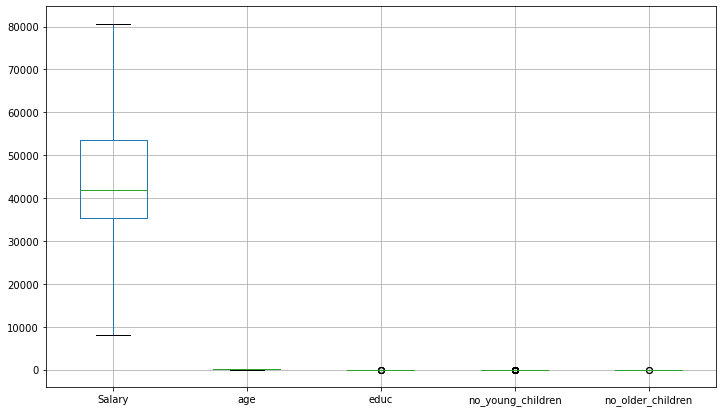

In [108]:
df.boxplot(figsize=(12,7))

In [109]:
from sklearn.preprocessing import LabelEncoder
LE=LabelEncoder()

In [110]:
df['foreign']=LE.fit_transform(df['foreign'])
df['Holliday_Package']=LE.fit_transform(df['Holliday_Package'])
df.head()

,Holliday_Package,Salary,age,educ,no_young_children,no_older_children,foreign
0,0,48412.0,30,8,1,1,0
1,1,37207.0,45,8,0,1,0
2,0,58022.0,46,9,0,0,0
3,0,66503.0,31,11,2,0,0
4,0,66734.0,44,12,0,2,0


In [111]:
X=df.drop('Holliday_Package',axis=1)
Y=df.pop('Holliday_Package')

In [112]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.30,random_state=1)

In [113]:
grid={'penalty':['l1', 'l2', 'elasticnet', 'none'],
      'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
      'tol':[0.0001,0.00001]}
model=LogisticRegression(max_iter=100000,n_jobs=2)
grid_search=GridSearchCV(estimator=model,param_grid=grid,cv=3,n_jobs=-1,scoring='f1')

In [114]:
grid_search.fit(X_train,Y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=100000, n_jobs=2),
             n_jobs=-1,
             param_grid={'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga'],
                         'tol': [0.0001, 1e-05]},
             scoring='f1')

In [115]:
print(grid_search.best_params_,'\n')
print(grid_search.best_estimator_)

{'penalty': 'l2', 'solver': 'newton-cg', 'tol': 0.0001} 

LogisticRegression(max_iter=100000, n_jobs=2, solver='newton-cg')


In [116]:
best_model = grid_search.best_estimator_

In [117]:
Y_train_predict=best_model.predict(X_train)
Y_test_predict=best_model.predict(X_test)

0.7409595610472651


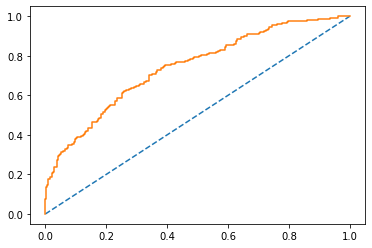

In [119]:
probs=best_model.predict_proba(X_train)
probs=probs[:,1]
auc=roc_auc_score(Y_train,probs)
print(auc)
fpr,tpr,thresholds=roc_curve(Y_train,probs)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr,tpr)

0.7049218980253462


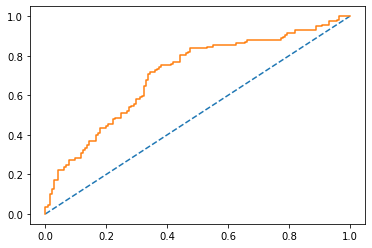

In [120]:
probs=best_model.predict_proba(X_test)
probs=probs[:,1]
auc=roc_auc_score(Y_test,probs)
print(auc)
fpr,tpr,thresholds=roc_curve(Y_test,probs)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr,tpr)

In [121]:
print(classification_report(Y_train,Y_train_predict))

              precision    recall  f1-score   support

           0       0.67      0.77      0.72       326
           1       0.68      0.56      0.62       284

    accuracy                           0.67       610
   macro avg       0.68      0.67      0.67       610
weighted avg       0.67      0.67      0.67       610



In [122]:
confusion_matrix(Y_train,Y_train_predict)

array([[251,  75],
       [124, 160]], dtype=int64)

In [123]:
print(classification_report(Y_test,Y_test_predict))

              precision    recall  f1-score   support

           0       0.67      0.70      0.69       145
           1       0.61      0.57      0.59       117

    accuracy                           0.65       262
   macro avg       0.64      0.64      0.64       262
weighted avg       0.64      0.65      0.64       262



In [124]:
confusion_matrix(Y_test,Y_test_predict)

array([[102,  43],
       [ 50,  67]], dtype=int64)

In [125]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [126]:
clf=LinearDiscriminantAnalysis()
model=clf.fit(X_train,Y_train)
model

LinearDiscriminantAnalysis()

0.7394798237276419


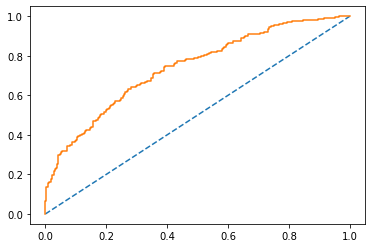

In [127]:
probs=model.predict_proba(X_train)
probs=probs[:,1]
auc=roc_auc_score(Y_train,probs)
print(auc)
fpr,tpr,thresholds=roc_curve(Y_train,probs)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr,tpr)

0.7029767167698201


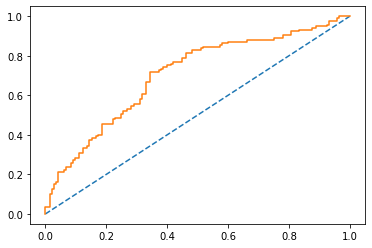

In [128]:
probs=model.predict_proba(X_test)
probs=probs[:,1]
auc=roc_auc_score(Y_test,probs)
print(auc)
fpr,tpr,thresholds=roc_curve(Y_test,probs)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr,tpr)

In [129]:
Y_train_predict=model.predict(X_train)
Y_test_predict=model.predict(X_test)

In [130]:
print(classification_report(Y_train,Y_train_predict))

              precision    recall  f1-score   support

           0       0.67      0.78      0.72       326
           1       0.69      0.56      0.61       284

    accuracy                           0.68       610
   macro avg       0.68      0.67      0.67       610
weighted avg       0.68      0.68      0.67       610



In [131]:
print(classification_report(Y_test,Y_test_predict))

              precision    recall  f1-score   support

           0       0.66      0.71      0.69       145
           1       0.61      0.56      0.58       117

    accuracy                           0.64       262
   macro avg       0.64      0.63      0.63       262
weighted avg       0.64      0.64      0.64       262



In [132]:
confusion_matrix(Y_train,Y_train_predict)

array([[254,  72],
       [126, 158]], dtype=int64)

In [133]:
confusion_matrix(Y_test,Y_test_predict)

array([[103,  42],
       [ 52,  65]], dtype=int64)